# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
9452                               SEO & Content Analyst   
2509            Data Scientist/Machine Learning Engineer   
9995                           Scheduling System Analyst   
1982                             Associate Data Engineer   
874    Practice Area Lead - Machine Learning - Data &...   
3646               Data Analyst - Intelligent Automation   
12182                         Technical Business Analyst   
3575                                  COMPUTER SCIENTIST   
10496                                Business Analyst II   
5530                     Data Analyst - People Analytics   

                                         Job Description  \
9452   What's This Position All About?\n\nAre you obs...   
2509   The Raytheon Intelligence and Space (RIS) Stra...   
9995   Department: PCMG Access Schedulers\n\nCategory...   
1982   Great sales are the result of strong purpose, ...   
874    About Slalom BuildSlalom Build is a highly-sca...   
3646   Category: ETL/Business Intelligence\nLocation:...   
12182  Description: Responsible for the operations of...   
3575   You will serve as a Computer Scientist in the ...   
10496  Primary FunctionThe Business Analyst II works ...   
5530   Job Description\nOnlineMedEd is focused on mak...   

                            Company Name             Location  \
9452                Perfect Search Media          Chicago, IL   
2509       Raytheon Intelligence & Space       Richardson, TX   
9995         Phoenix Children's Hospital          Phoenix, AZ   
1982                           OptumCare      San Antonio, TX   
874                               Slalom          Chicago, IL   
3646   Prudent Technologies & Consulting       Fort Worth, TX   
12182                       Diverse Lynx           Austin, TX   
3575                           U.S. Navy     Jacksonville, FL   
10496    Contemporary Staffing Solutions  Fort Washington, PA   
5530                         OnlineMedEd           Austin, TX   

                  City State     Remote          Size  Founded  \
9452           Chicago    IL  Uncertain    Very Small   2010.0   
2509        Richardson    TX  Uncertain    Very Large   2020.0   
9995           Phoenix    AZ  Uncertain  Medium-Large   1983.0   
1982       San Antonio    TX  Uncertain        Medium      NaN   
874            Chicago    IL  Uncertain         Large   2001.0   
3646        Fort Worth    TX  Uncertain         Small   1998.0   
12182           Austin    TX  Uncertain        Medium   2002.0   
3575      Jacksonville    FL  Uncertain  Medium-Large   1775.0   
10496  Fort Washington    PA  Uncertain  Medium-Large   1994.0   
5530            Austin    TX  Uncertain         Small   2014.0   

                             Industry  Rating  SalaryMin  SalaryMax  \
9452            Advertising Marketing     4.2         69         97   
2509                Aerospace Defense     3.5        134        210   
9995   Health Care Services Hospitals     3.9         51         99   
1982   Health Care Services Hospitals     3.4         54         92   
874                        Consulting     4.1         76        147   
3646                      IT Services     4.2         47         84   
12182                     IT Services     3.9         46         84   
3575                 Federal Agencies     3.8         54         88   
10496            Staffing Outsourcing     4.4         78        139   
5530            Colleges Universities     4.6         42         76   

       Salary Estimate   DF  
9452              83.0  DF1  
2509             172.0  DF1  
9995              75.0  DF1  
1982              73.0  DF1  
874              111.5  DF1  
3646              65.5  DF1  
12182             65.0  DF1  
3575              71.0  DF1  
10496            108.5  DF1  
5530              59.0  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
1810  Biopharmaceutical Drug Product, Principal Scie...   
592   VRL - Clinical Histocompatibility Scientist Tr...   
1834                         PD Downstream Sr Scientist   
1541                 Marketing Data Analyst Coordinator   
2429  Genomics Field Applications Scientist, North A...   
3754         Scientist/Engineer, Process & Formulations   
3162                                      Data Engineer   
624                                       Data Engineer   
1808                      Business Intelligence Analyst   
3455                                 9-1-1 Data Analyst   

                                        Job Description  \
1810  Site Name: USA - Pennsylvania - Upper Providen...   
592   Company Description\n\nVRL Eurofins has a nati...   
1834  Join the Spark Team\n\nWe were born of innovat...   
1541  TAILWIND, a division of Audacious Studios is l...   
2429  Beckman Coulter develops, manufactures and mar...   
3754  Here at Scotts Miracle-Gro there is no such th...   
3162  Position Senior Data Engineer Location Menlo P...   
624   Develops and maintains scalable cloud-based in...   
1808  Position Overview:\n\nThe Business Intelligenc...   
3455  Responsibilities include:\n\n• Facilitating op...   

                       Company Name          Location          City State  \
1810                            GSK  Collegeville, PA  Collegeville    PA   
592             Eurofins Scientific   Los Angeles, CA   Los Angeles    CA   
1834             Spark Therapeutics  Philadelphia, PA  Philadelphia    PA   
1541          AUDACIOUS STUDIOS LLC         Tempe, AZ         Tempe    AZ   
2429  Beckman Coulter Life Sciences     San Diego, CA     San Diego    CA   
3754             Scotts Miracle-Gro      Columbus, OH      Columbus    OH   
3162                       Indrasol    Menlo Park, CA    Menlo Park    CA   
624                  NortonLifeLock   Culver City, CA   Culver City    CA   
1808                        SDI Inc       Bristol, PA       Bristol    PA   
3455             911 Datamaster Inc        Austin, TX        Austin    TX   

         Remote          Size  Founded                            Industry  \
1810  Uncertain    Very Large   1830.0           Biotech & Pharmaceuticals   
592   Uncertain    Very Large   1987.0           Biotech & Pharmaceuticals   
1834  Uncertain  Medium-Small      NaN           Biotech & Pharmaceuticals   
1541  Uncertain           NaN      NaN                                 NaN   
2429  Uncertain    Very Large   1935.0  Health Care Products Manufacturing   
3754  Uncertain         Large   1868.0     Consumer Products Manufacturing   
3162  Uncertain    Very Small      NaN                                 NaN   
624   Uncertain  Medium-Large   2019.0                            Internet   
1808  Uncertain  Medium-Small   1971.0            Logistics & Supply Chain   
3455        Yes    Very Small      NaN        Computer Hardware & Software   

      Rating SalaryMin SalaryMax  Salary Estimate   DF  
1810     3.9        45      106               NaN  DF2  
592      3.4        34       72               NaN  DF2  
1834     3.2        71      122               NaN  DF2  
1541     NaN        97      111               NaN  DF2  
2429     3.4        62      127               NaN  DF2  
3754     4.1       100      163               NaN  DF2  
3162     5.0       141      225               NaN  DF2  
624      3.7        37       75               NaN  DF2  
1808     3.0        45      106               NaN  DF2  
3455     NaN        41       66               NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
183             Data Modeler - Data Solutions Engineer   
430                                Senior Data Modeler   
308  Client Delivery Manager - Data Science and Ana...   
707                                     Data Scientist   
68                           Machine Learning Engineer   
445                                     Data Scientist   
200                                     Data Scientist   
794                                     Data Scientist   
279                                     Data Scientist   
307                          Machine Learning Engineer   
323  Software Engineer (Data Scientist, C,C++,Linux...   
434                                   NLP DATA SCIENCE   
285                              Scientist, Toxicology   
447                                 Sr. Data Scientist   
313               Sr. Scientist - Structural Chemistry   
670                                     Data Scientist   
101                            Principal Data Engineer   
838                                     Data Scientist   
362                               Senior Data Engineer   
773                                     Data Scientist   

                                       Job Description  \
183  The Data & Analytics Engineering organization ...   
430  We're looking for an innovative Data Modeler t...   
308  The Role\n\nThe Spur Group is looking for a Cl...   
707  We are Mythical Games. A venture-backed next-g...   
68   Returning Candidate? Log back in to the Career...   
445  Location: Anywhere in the US or Canada | Locat...   
200  About MuteSix:\n\nMuteSix, an iProspect compan...   
794  Job Summary\n\nTEKsystems is seeking a skilled...   
279  Job Duties & Responsibilities\nBring Creativit...   
307  Who Are We?\n\nQinetiQ Inc. is an innovative C...   
323  During the current global health crisis, the p...   
434  Ultimate Software continues to invest in a mod...   
285  The Role:\nThe Scientist will lead all aspects...   
447  Be proud of where you work, be proud of your C...   
313  Support the daily operations of the Structural...   
670  Need local to Bay Area, CA or Seattle, WA only...   
101  About the Company…\n\nNu Skin was founded in 1...   
838  About Us\nAt Cloudflare, we have our eyes set ...   
362  The Genesys Cloud Analytics platform is the fo...   
773  Job Summary\n\n\nWe are searching for a Data S...   

                        Company Name             Location             City  \
183         Liberty Mutual Insurance          Seattle, WA          Seattle   
430  First Tech Federal Credit Union          Rocklin, CA          Rocklin   
308                   The Spur Group          Redmond, WA          Redmond   
707                   Mythical Games      Los Angeles, CA      Los Angeles   
68      Riverside Research Institute      Beavercreek, OH      Beavercreek   
445                       TA Digital         New York, NY         New York   
200                          MuteSix      Los Angeles, CA      Los Angeles   
794                       TEKsystems        Baltimore, MD        Baltimore   
279                        BlackLine   Woodland Hills, CA   Woodland Hills   
307                             Mteq     Fort Belvoir, VA     Fort Belvoir   
323                  Mentor Graphics          Fremont, CA          Fremont   
434                Ultimate Software  Fort Lauderdale, FL  Fort Lauderdale   
285             Moderna Therapeutics        Cambridge, MA        Cambridge   
447                          Navient          Fishers, IN          Fishers   
313     Nitto Avecia Pharma Services           Irvine, CA           Irvine   
670     New York Technology Partners          Seattle, WA          Seattle   
101                          Nu Skin            Provo, UT            Provo   
838                 Cloudflare, Inc.           Austin, TX           Austin   
362                          Genesys           Durham, NC           Durham   
773        Texas Children's Hospital          H

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
1597                      RM - Data Maintenance Analyst   
294   Senior Data Analyst - Data Cataloging / Data P...   
1255                Division Data and Financial Analyst   
8                                          Data Analyst   
737                              Outsights Data Analyst   
289                               Clinical Data Analyst   
1352                                       Data Analyst   
308   ETL Datastage Developer/IBM Infosphere Datasta...   
565                                 Senior Data Analyst   
706                                    Sr Analyst, Data   

                                        Job Description  \
1597  Description/Comment:Responsibilities includes ...   
294   Role Senior Data Analyst - Data Cataloging Dat...   
1255  This position will remain open until filled.UC...   
8     The Data Analyst is an integral member of the ...   
737   Passionate about making a difference in the wo...   
289   SoluStaff is actively recruiting for a full-ti...   
1352  Job Description\nETL, SQL Queries, Data Modeli...   
308   Position Details:\n\nJob Title: Sr. Datastage ...   
565   Who we are\n\nLucky Day Entertainment, Inc. is...   
706   Job Description\n\nJob Summary\nDesigns and im...   

                     Company Name           Location           City State  \
1597                   eTeam Inc.  Mountain View, CA  Mountain View    CA   
294   Reliable Software Resources       New York, NY       New York    NY   
1255     University of California      San Diego, CA      San Diego    CA   
8                            DMGT       New York, NY       New York    NY   
737                        Tempus        Chicago, IL        Chicago    IL   
289                     SoluStaff       Brooklyn, NY       Brooklyn    NY   
1352                            1         Dallas, TX         Dallas    TX   
308                  TechProjects       New York, NY       New York    NY   
565                     Lucky Day    Los Angeles, CA    Los Angeles    CA   
706             Molina Healthcare     Long Beach, CA     Long Beach    CA   

         Remote        Size  Founded                          Industry  \
1597  Uncertain       Small   1999.0            Staffing & Outsourcing   
294         Yes      Medium   2004.0                       IT Services   
1255  Uncertain  Very Large   1868.0           Colleges & Universities   
8     Uncertain       Large   1896.0  Venture Capital & Private Equity   
737   Uncertain       Small   1999.0  Financial Transaction Processing   
289   Uncertain  Very Small      NaN                       IT Services   
1352  Uncertain         NaN      NaN                               NaN   
308   Uncertain  Very Small   2011.0                       IT Services   
565   Uncertain  Very Small   2014.0                          Internet   
706   Uncertain  Very Large   1980.0                Insurance Carriers   

      Rating SalaryMin SalaryMax  Salary Estimate  DF  
1597     3.7        58       93               NaN  DA  
294      4.0        27       52               NaN  DA  
1255     4.2        76      122               NaN  DA  
8        4.0        37       66               NaN  DA  
737      3.3        60       66               NaN  DA  
289      NaN        27       52               NaN  DA  
1352     NaN        30       53               NaN  DA  
308      4.8        27       52               NaN  DA  
565      4.0        37       70               NaN  DA  
706      3.1       113      132               NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
854                       Data Engineer   
724          Data Center Power Engineer   
2421           Mission Systems Engineer   
888                   Big-Data Engineer   
281   Experienced RF/Microwave Engineer   
475            Senior Database Engineer   
1146            Data Warehouse Engineer   
2330                  Data Engineer III   
1376           Senior Software Engineer   
414   Senior Mobile Engineer (Contract)   

                                        Job Description  \
854   Position: Data Engineer\nLocation: currently r...   
724   The Data Center Power Engineer reports to the ...   
2421  Bell is seeking a Mission Systems Design Engin...   
888   Big Data Engineer (5+ years)\n\nTech Stack : J...   
281   At Boeing, we are all innovators on a mission ...   
475   Your Opportunity\n\n\nDo you want to work on d...   
1146  Piper Companies is looking for a Data Warehous...   
2330  Blucora has a bold aspiration: we are committe...   
1376  Since H-E-B Digital Technology's inception, we...   
414   Kin + Carta is hiring a Senior Mobile Engineer...   

                       Company Name             Location             City  \
854                 PeopleNTech LLC         Chandler, AZ         Chandler   
724   Enchanted Rock Management LLC          Houston, TX          Houston   
2421                        Textron       Fort Worth, TX       Fort Worth   
888                      Nucleusteq          Phoenix, AZ          Phoenix   
281                          BOEING      Los Angeles, CA      Los Angeles   
475                       New Relic          Chicago, IL          Chicago   
1146                Piper Companies  Fort Washington, PA  Fort Washington   
2330      Avantax Wealth Management           Irving, TX           Irving   
1376                          H E B      San Antonio, TX      San Antonio   
414                     Kin + Carta          Chicago, IL          Chicago   

     State     Remote          Size  Founded                       Industry  \
854     AZ        Yes    Very Small      NaN                    IT Services   
724     TX  Uncertain           NaN      NaN                            NaN   
2421    TX  Uncertain    Very Large   1923.0            Aerospace & Defense   
888     AZ  Uncertain  Medium-Small   2018.0                    IT Services   
281     CA  Uncertain    Very Large   1916.0            Aerospace & Defense   
475     IL        Yes  Medium-Large   2008.0   Computer Hardware & Software   
1146    PA  Uncertain  Medium-Small   2011.0         Staffing & Outsourcing   
2330    TX  Uncertain        Medium   1983.0             Brokerage Services   
1376    TX  Uncertain    Very Large   1905.0  Grocery Stores & Supermarkets   
414     IL  Uncertain  Medium-Large   2001.0                     Consulting   

      Rating SalaryMin SalaryMax  Salary Estimate  DF  
854      4.3        79      104               NaN  DE  
724      NaN        69      103               NaN  DE  
2421     3.3       100      160               NaN  DE  
888      5.0        81      141               NaN  DE  
281      3.7        79      146               NaN  DE  
475      4.6       133      210               NaN  DE  
1146     4.5        55      105               NaN  DE  
2330     1.7        65      120               NaN  DE  
1376     4.3        52       63               NaN  DE  
414      4.1        56      108               NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
126            Data Scientist   
787          FGP Data Analyst   
303   QC Scientist III FM BSD   
582            Data Scientist   
648            Data Scientist   
56      Senior Data Scientist   
569     Business Data Analyst   
358            Data Scientist   
643  Director of Data Science   
61             Data Scientist   

                                       Job Description        Company Name  \
126  Data Scientist, St. Louis, MO\n\n***No c2c or ...        Envision LLC   
787  NYU Langone Health is a world-class, patient-c...  NYU Langone Health   
303  QC Scientist III FM BSD\n\nThe Swiss based Bac...              Bachem   
582  Job Description:\nProvide Subject Matter Exper...        CICONIX, LLC   
648  Mooresville, North Carolina\nSkills : Data Sci...           Collabera   
56   The ultimate source for official answers about...                Yext   
569  Overview\n\n\nWe are seeking a Business Data A...       Intuit - Data   
358  Social Sentinel is looking for a Data Scientis...     Social Sentinel   
643  Overview\n\n\nAnalysis Group is one of the lar...      Analysis Group   
61   Learn and work on meaningful initiatives with ...                 NPD   

                     Location                  City State     Remote  \
126           Saint Louis, MO           Saint Louis    MO  Uncertain   
787              New York, NY              New York    NY  Uncertain   
303                 Vista, CA                 Vista    CA  Uncertain   
582  Wright Patterson AFB, OH  Wright Patterson AFB    OH  Uncertain   
648           Mooresville, NC           Mooresville    NC        Yes   
56               New York, NY              New York    NY  Uncertain   
569        Woodland Hills, CA        Woodland Hills    CA  Uncertain   
358            Burlington, VT            Burlington    VT  Uncertain   
643                Boston, MA                Boston    MA  Uncertain   
61        Port Washington, NY       Port Washington    NY  Uncertain   

             Size  Founded                          Industry  Rating  \
126  Medium-Small   1994.0            Staffing & Outsourcing     4.5   
787    Very Large   1841.0  Health Care Services & Hospitals     4.0   
303        Medium   1971.0         Biotech & Pharmaceuticals     3.0   
582    Very Small      NaN                  Federal Agencies     4.0   
648    Very Large   1991.0                       IT Services     4.1   
56   Medium-Large   2006.0                          Internet     4.3   
569         Large   1983.0      Computer Hardware & Software     4.4   
358    Very Small   2016.0                          Internet     4.8   
643  Medium-Large   1981.0                        Consulting     3.7   
61   Medium-Large   1966.0            Research & Development     3.9   

    SalaryMin SalaryMax  Salary Estimate  DF  
126        59      101               NaN  DS  
787        76      127               NaN  DS  
303        89      148               NaN  DS  
582        74      127               NaN  DS  
648        51       92               NaN  DS  
56         86      143               NaN  DS  
569        74      127               NaN  DS  
358        82      141               NaN  DS  
643        51       92               NaN  DS  
61         15       16               NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
22911                                       Data Analyst   
19817      Geospatial Social Science Statistical Analyst   
1489                             Big Data Engineer/Admin   
17382                Data Engineer with TS/SCI with Poly   
13135                                  Sr Data Scientist   
23980    Big Data Engineer (with Azure Data factory Exp)   
18472                                     Data Scientist   
21083                                    Product Manager   
9304                           Global Macro News Analyst   
5058                              Virology Data Analysts   
6969                                     Sr Data Analyst   
20752                        Principal Data Science Lead   
23329                               Data Analyst, Growth   
2259                                       Data Engineer   
14224  Senior Scientist, CAR-T Analytical Development...   
3907                                        Data Analyst   
11565                                 Business Architect   
21331                       Senior Manager of Technology   
21218  Epidemiology or Data Science of Aging-Tenure-t...   
11896      Global Capital Markets Summer Analyst Program   

                                         Job Description  \
22911  Data Analyst\nIf you are a Data Analyst with e...   
19817  10 years of experience with geospatial analysi...   
1489   NOTE: ONLY GREEN CARD HOLDERS and U.S. CITIZEN...   
17382  Support of production data processing and data...   
13135  Job Description\nWhat We Do\nKalderos delivers...   
23980  Job Title Big Data Engineer (with Azure Data f...   
18472  As a Data Scientist you will join the Business...   
21083  At Progressive Leasing, we pride ourselves in ...   
9304   LIFE AT IMC AS GLOBAL MACRO NEWS ANALYST\n\nWH...   
5058   Company Description\nEurofins Scientific is an...   
6969   Do you want your voice heard and your actions ...   
20752  Microsoft envisions a world where passionate i...   
23329  Omada Health is on a mission to inspire and en...   
2259   Job Description:\nBachelors or Masters in Comp...   
14224  Janssen Pharmaceutical, a member of Johnson & ...   
3907   About Us\n\nAt Teachers Pay Teachers (TpT), we...   
11565  To get the best candidate experience, please c...   
21331  “It takes people to make the dream a reality.”...   
21218  DescriptionEpidemiology or Data Science of Agi...   
11896  City\nMenlo Park\n\nEducation Level\nBachelor'...   

                               Company Name           Location           City  \
22911                           CyberCoders   Redwood City, CA   Redwood City   
19817                   Booz Allen Hamilton    MacDill AFB, FL    MacDill AFB   
1489   Allstate Insurance - 1202 Irving, TX          Tempe, AZ          Tempe   
17382                                Leidos         Aurora, CO         Aurora   
13135                              Kalderos        Chicago, IL        Chicago   
23980              Resource Logistics, Inc.    Los Angeles, CA    Los Angeles   
18472                  Raymour and Flanigan      Liverpool, NY      Liverpool   
21083                   Progressive Leasing         Draper, UT         Draper   
9304                  IMC Financial Markets        Chicago, IL        Chicago   
5058                               Eurofins     West Point, PA     West Point   
6969                                   MUFG          Tempe, AZ          Tempe   
20752                             Microsoft        Redmond, WA        Redmond   
23329                          Omada Health  San Francisco, CA  San Francisco   
2259                          CYNET SYSTEMS      San Diego, CA      San Diego   
14224               J&J Family of Companies        Malvern, PA        Malvern   
3907                  Teachers Pay Teachers       New York, NY       New York   
11565                            Salesforce         Dallas, TX         Dallas   
21331                       The Job Network   Winter Haven, FL   Wi

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

#dropping job duplicates with no salary coluumns
criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataSet
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### NLP

In [14]:
#! pip install contractions
#nltk.download('all')

In [15]:
#Removing contractions, punctuations, @, and lemmatizations
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        if "scala" == word:
            sentence.append('scala')
            continue
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 

# make new column for edited job description
FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7143     description lead participate design build mana...
8653     company overview memorial sloan kettering msk ...
                               ...                        
27040    great big data analytics security engineer fis...
27041    title data scientist springfield va term hire ...
27042    responsibility include support team developer ...
27043    continue impact covid 19 social distance measu...
27044    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16206, dtype: object

In [16]:
#remove common job description words
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    stat=r"(statistical)"
    x=re.sub(stat,"statistic",x)
    an=r"(analyze)"
    x=re.sub(an,"analytical",x)
    dl=r"(deep learn)"
    x=re.sub(bd,"bigdata",x)
    x=re.sub(dl,"deeplearning",x)
    ai=r"(artificial intelligence)"
    x=re.sub(ai,"ai",x)
    replaced=r'(\·|\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b|\badvance\b|\bandor\b|\bapply\b|\bcommunication\b|\bcomputer\b|\bcreate\b|\bdegree\b|\bdocument\b|\bemployee\b|\bemployment\b|\bensure\b|\benvironment\b|\bfunctional\b|\bhelp\b|\bidentify\b|\binsight\b|\blarge\b|\blead\b|\blearn\b|\blevel\b|\bmake\b|\bmanage\b|\bmarket\b|\bmay\b|\bmeet\b|\bmust\b|\boperation\b|\bperform\b|\bplan\b|\bprefer\b|\brelate\b|\breport\b|\brequirement\b|\bresponsibility\b|\bstatus\b|\btechnique\b|\btime\b|\buser\b|\bworld\b|\bwrite\b|\baccount\b|\bacross\b|\bassist\b|\bbest\b|\bcandidate\b|\bchange\b|\bcomplex\b|\bdecision\b|\bdetail\b|\bdisability\b|\bdocumentation\b|\beducation\b|\betc\b|\bexcellent\b|\bfield\b|\bhealth\b|\bhigh\b|\bimplement\b|\bimplementation\b|\bindustry\b|\bissue\b|\bmaintain\b|\bmultiple\b|\boffice\b|\borganization\b|\bpartner\b|\bpeople\b|\bperformance\b|\breview\b|\brisk\b|\bsecurity\b|\bsolve\b|\bsource\b|\bstakeholder\b|\btrain\b|\bu\b|\bwell\b|\bwithin\b|\b3\b|\b5\b|\bable\b|\bapplicant\b|\bbachelor\b|\bbenefit\b|\bcommunicate\b|\bdefine\b|\bdeliver\b|\bdemonstrate\b|\bend\b|\bequivalent\b|\bfunction\b|\bgather\b|\bimprove\b|\bimprovement\b|\bindividual\b|\binternal\b|\bkey\b|\blanguage\b|\blook\b|\bone\b|\bpay\b|\bpolicy\b|\bpractice\b|\bpredictive\b|\bprofessional\b|\bqualification\b|\bquantitative\b|\bresponsible\b|\bresult\b|\bsale\b|\bset\b|\b2\b|\bactivity\b|\barea\b|\bassign\b|\bcase\b|\bcomplete\b|\bdepartment\b|\bemployer\b|\bfederal\b|\bfocus\b|\bfollow\b|\blike\b|\blocation\b|\bmanager\b|\bmember\b|\boffer\b|\bplus\b|\bprocedure\b|\bspecification\b|\bstate\b|\bvalue\b|\bvarious\b|\bcareer\b|\bcompliance\b|\beffectively\b|\bfind\b|\bgroup\b|\bimpact\b|\blaw\b|\bminimum\b|\bmonitor\b|\boperational\b|\bparticipate\b|\bplease\b|\bprotect\b|\brequest\b|\bstaff\b|\bstandard\b|\bstrategy\b|\bveteran\b|\bgood\b|\baction\b|\bbank\b|\bcare\b|\bconduct\b|\bcontract\b|\bcost\b|\benterprise\b|\bglobal\b|\bhealthcare\b|\bmethodology\b|\bqualify\b|\bregard\b|\bresource\b|\bserve\b|\beg\b|\bmethod\b|\bexpertise\b|\bchallenge\b|\bgrow\b|\bapproach\b|\balso\b|\bagile\b|\bstory\b|\bcross\b|\bexist\b|\bcurrent\b|\bday\b|\bfull\b|\bpart\b|\binsurance\b|\breligion\b|\bcurrent\b|\b1\b|\bbi\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform   next gen...
7143                   scale   structure pipeline effic...
8653       overview memorial sloan kettering msk   way ...
                               ...                        
27040    great bigdata       fiserv passionate   want s...
27041    title     springfield va term hire     salary ...
27042          team developer       variety research   ...
27043    continue   covid 19 social distance measure ke...
27044        tssci poly clearance     tssci poly   mcle...
Name: edit_jobDescription, Length: 16206, dtype: object

In [17]:
#fix huge amount of different job title names
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 


#make new coolumn with edited job title
FDSword['edit_jobTitle']=FDSword['Job Title'].dropna().apply(lambda x: fixTitle(x))
FDSword['edit_jobTitle']

1712        Data Engineer
2144       Data Scientist
3078       Data Scientist
7143        Data Engineer
8653     Business Analyst
               ...       
27040            Big Data
27041      Data Scientist
27042      Data Scientist
27043    Machine Learning
27044      Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [18]:
FDSword = FDSword[FDSword['edit_jobTitle'] != "Sales"]
FDSword = FDSword[FDSword['edit_jobTitle'] != "Environmental Scientist"]
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Clinical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Medical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Workforce Analyst']


In [19]:
FDSword.to_csv('FullDataSet.csv')

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence'
 'Cyber Security' 'Researcher' 'Scientist' 'Data Modeler' 'Data Architect'
 'Research Scientist' 'Machine Learning' 'Developer' 'Applied Scientist'
 'Big Data' 'Computer Scientist' 'Engineer' 'Product Manager'
 'Systems Engineer' 'Research Engineer' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
28


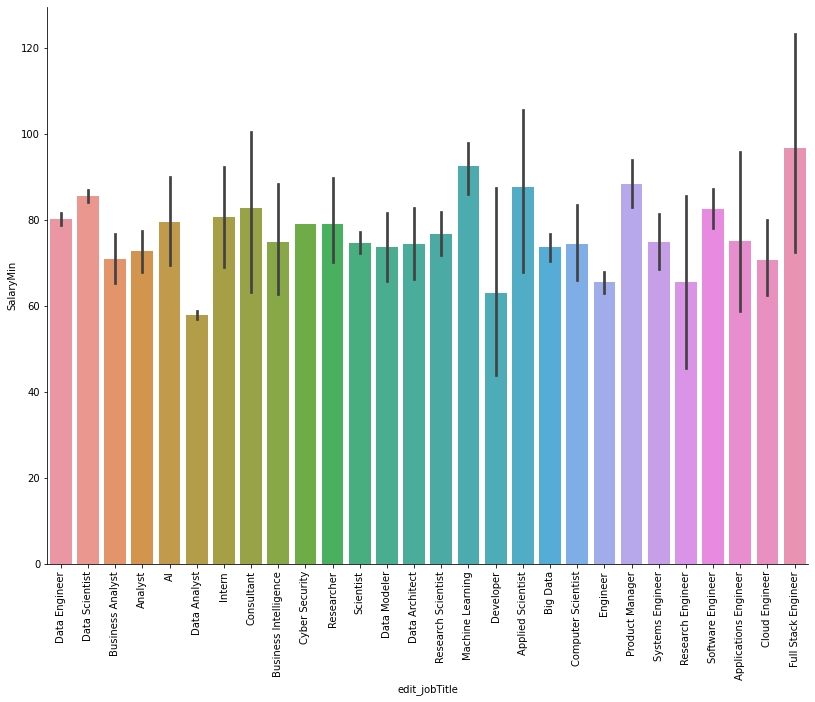

In [20]:
import seaborn as sns

uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))
# sns.set(rc={'figure.figsize':(30,10)})
mini =sns.catplot(x="edit_jobTitle",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
mini.set_xticklabels(rotation=90)
#plt.legend(labels=uniqueJobTitles);

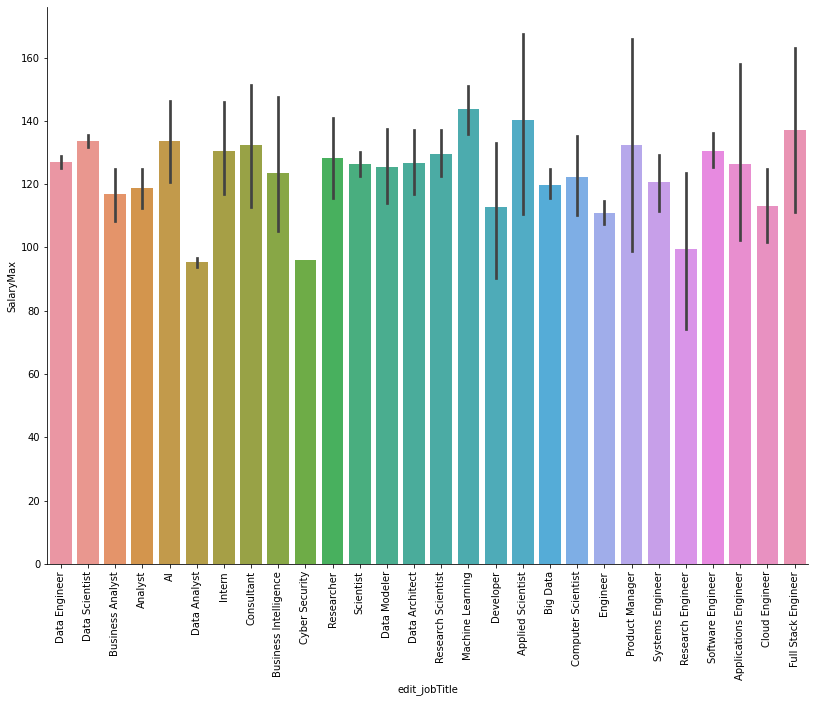

In [21]:
maxi =sns.catplot(x="edit_jobTitle",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxi.set_xticklabels(rotation=90);

In [40]:
def state(x):
    if x=="Florida":
        x="FL"
    if x==' CO':
        x="CO"
    if x==" NM":
        x="NM"
    if x==" CA":
        x="CA"
    if x==" NY":
        x="NY"
    if x==" WA":
        x="WA"
    if x==" UT":
        x="UT"
    if x==" TX":
        x="TX"        
    if x==" FL":
        x="FL"
    else:
        x=x
    return x
        
FDSword['State']=FDSword['State'].apply(lambda x: state(x))

In [41]:
miniState =sns.catplot(x="State",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
miniState.set_xticklabels(rotation=90);

In [35]:
uniqueState=FDSword.State.unique()
print((uniqueState))
print((len(uniqueState)))

['PA' 'CA' 'NY' 'NJ' 'IL' 'TX' 'AZ' 'DE' 'FL' 'OH' 'VA' 'KS' 'GA' 'OR'
 'MD' 'MA' 'UT' 'SC' 'WI' 'NV' 'DC' 'WV' 'WA' 'NM' 'RI' 'NC' 'TN' 'ME'
 'MO' 'CT' 'CO' 'MI' nan 'IN' 'MS' 'LA' 'NE' 'IA' 'MN' 'ND' 'OK' 'AL' 'KY'
 'NH' 'ID' 'HI' 'AR' 'VT' 'WY' 'SD']
50


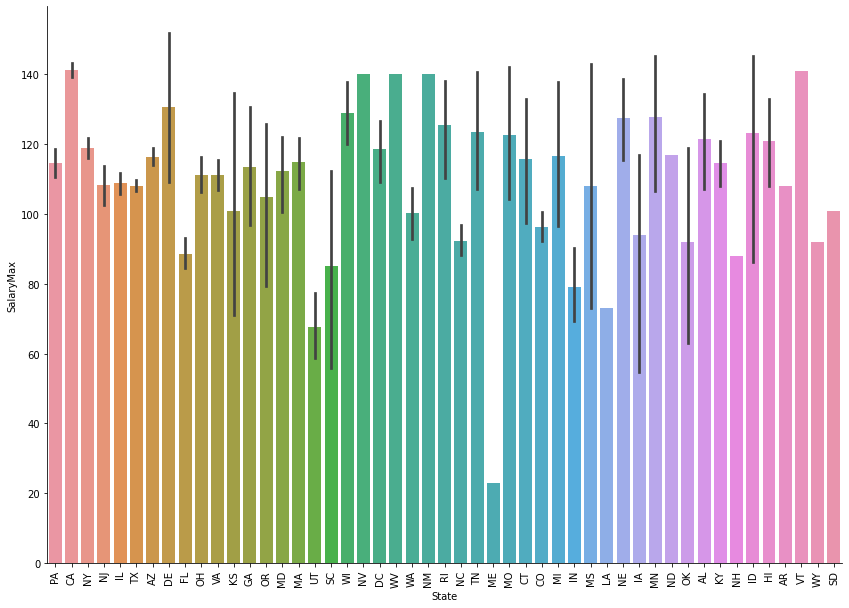

In [42]:
maxiState =sns.catplot(x="State",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxiState.set_xticklabels(rotation=90);

In [26]:
profileJT = pp.ProfileReport(FDSword.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profileJT

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

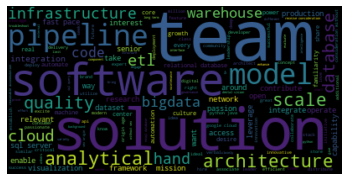

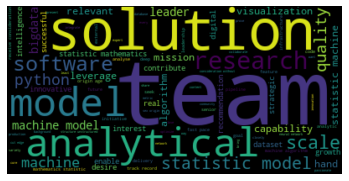

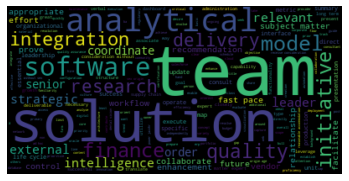

In [27]:
from wordcloud import WordCloud
#collocations=False
# jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'AI',
#  'Data Analyst', 'Intern', 'Consultant', 'Business Intelligence', 'Sales',
#  'Workforce Analyst' ,'Cyber Security' ,'Researcher', 'Scientist',
#  'Data Modeler', 'Data Architect', 'Research Scientist',
#  'Machine Learning Scientist', 'Developer', 'Applied Scientist',
#  'Machine Learning Engineer', 'Big Data', 'Environmental Scientist',
#  'AI Engineer', 'Clinical Scientist', 'Computer Scientist', 'Engineer',
#  'Medical Scientist', 'Product Manager', 'Systems Engineer',
#  'Research Engineer', 'Machine Learning', 'Software Engineer',
#  'Applications Engineer', 'Cloud Engineer', 'Full Stack Engineer']

filterList=[]
def fun(x):
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    words=pd.Series(abc.split())
#     print(words.value_counts().sort_values(ascending=False).head(20))
    filterList.append(words.value_counts().sort_values(ascending=False).head(25))
    
    print("\n")

# print(filterList)
    

In [28]:
# from wordcloud import WordCloud
# #collocations=False
# test = pd.read_csv("test.csv")
# def fun(x):
#     if x is None:
#         return ""
#     wordList.append(x)
    
# jt=['Data Engineer']

# for job in jt:
#     wordList=[]
#     FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))  
#     abc=" ".join(wordList)
#     wordcloud = WordCloud().generate(abc)
#     # Display the generated image:      
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")
#     print(job)
#     plt.show()
#     testing=[w for w in abc.split() if 'scala' == w ]
#     print(len(testing))
#     words=pd.Series(abc.split())
#     print(words)
#     print(words.value_counts().sort_values(ascending=False).head(20))
    
#     print("\n")

In [29]:
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r
def junior(x):
    x=x.lower()
    if "junior" in x or "jr" in x:
        r=1
    else:
        r=np.nan
    return r

        

#Senior = x[16]
#sen= x[23]
FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))
FullDataSet['jun']=FullDataSet['Job Description'].dropna().apply(lambda x: junior(x))
FullDataSet['Senior'].fillna(FullDataSet['sen'], inplace=True)
FullDataSet['Junior'].fillna(FullDataSet['jun'], inplace=True)

In [30]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())

1299.0
252.0
1042.0


In [31]:
FullDataSet[FullDataSet['jun']==1]

Job Title  \
8665   Senior Analyst, Business Intelligence (Looker BI)   
8685                                    Business Analyst   
8733                                    Business Analyst   
8768                                    Business Analyst   
8862                                    Business Analyst   
...                                                  ...   
26922                           Senior Big Data Engineer   
26936            Principal Data Scientist - R&D Oncology   
26940  Senior Scientist - Statistician (Product Integ...   
26944                                     Data Scientist   
27037         Scientist - Early Respiratory & Immunology   

                                         Job Description  \
8665   CB Insights has millions of readers, hundreds ...   
8685   Job Description\nMemo is: The manager is looki...   
8733   Job Description\nDescription\n\nWe are hiring ...   
8768   Junior Sales Representative\n\nVela is a leadi...   
8862   Job Description\nJob Summary:\nLooking for hig...   
...                                                  ...   
26922  Do you want to be part of the transformation t...   
26936  Job Description / Capsule\n\nThe Machine Learn...   
26940  British American Tobacco\nReynolds American In...   
26944  The Data Scientist position is a full-time emp...   
27037  Are you a passionate Scientist thriving to mak...   

                           Company Name           Location           City  \
8665                        CB Insights       New York, NY       New York   
8685         Russell Tobin & Associates    Jersey City, NJ    Jersey City   
8733                         ConsultAdd       New York, NY       New York   
8768                       Options City       New York, NY       New York   
8862   Staffigo Technical Services, LLC       New York, NY       New York   
...                                 ...                ...            ...   
26922                             GEICO    Chevy Chase, MD    Chevy Chase   
26936                       AstraZeneca       New York, NY       New York   
26940                 Reynolds American  Winston-Salem, NC  Winston-Salem   
26944                             Zovio       Chandler, AZ       Chandler   
27037                       AstraZeneca   Gaithersburg, MD   Gaithersburg   

      State     Remote          Size  Founded  \
8665     NY  Uncertain  Medium-Small   2009.0   
8685     NJ  Uncertain         Small   2010.0   
8733     NY  Uncertain         Small      NaN   
8768     NY  Uncertain   SizeUnknown      NaN   
8862     NY  Uncertain         Small   2008.0   
...     ...        ...           ...      ...   
26922    MD        Yes    Very Large   1936.0   
26936    NY  Uncertain    Very Large   1913.0   
26940    NC  Uncertain         Large   1875.0   
26944    AZ  Uncertain  Medium-Large   2004.0   
27037    MD  Uncertain    Very Large   1913.0   

                                    Industry  ...  Junior  Senior   DF  \
8665   Enterprise Software Network Solutions  ...     1.0     NaN  DF1   
8685                    Staffing Outsourcing  ...     1.0     NaN  DF1   
8733                             IT Services  ...     1.0     NaN  DF1   
8768                                     NaN  ...     1.0     NaN  DF1   
8862                             IT Services  ...     1.0     1.0  DF1   
...                                      ...  ...     ...     ...  ...   
26922                     Insurance Carriers  ...     1.0     1.0   DS   
26936              Biotech & Pharmaceuticals  ...     1.0     1.0   DS   
26940        Consumer Products Manufacturing  ...     1.0     1.0   DS   
26944                Colleges & Universities  ...     1.0     NaN   DS   
27037              Biotech & Pharmaceuticals  ...     1.0     NaN   DS   

                                     edit_jobDescription     edit_jobTitle  \
8665   cb   million reader hundred thousand prospect ...  Business Analyst   
8685       memo       businessproduct         

In [32]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Menlo Park           115
Redmond              115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Charlotte             84
Tampa                 84
Redwood City          84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Santa Monica          58
Jersey City           58
Miami                 56
San Mateo             53
Arlington             51
Chandler              51
Glendale              50
Brooklyn              49
Cambridge             48
Santa Clara Valley    48
Fremont               47

In [33]:
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-33-680448283021>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-33-680448283021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-33-680448283021>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  